In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal
from patchify import patchify

In [ ]:
import numpy as np
import rasterio
import fiona
import zipfile

load_tif_as_array produces NaNs

In [2]:
#pip install GDAL-3.4.3-cp39-cp39-win_amd64.whl

In [3]:
def get_tile_info(refDataset):
    tile_info = {}
    tile_info['projection'] = refDataset.GetProjection()
    tile_info['geotransform'] = refDataset.GetGeoTransform()
    tile_info['width'] = refDataset.RasterXSize
    tile_info['height'] = refDataset.RasterYSize
    return tile_info
def load_tif_as_array(path, set_nodata_to_nan=True):
    ds = gdal.Open(path)
    band = ds.GetRasterBand(1)
    array = band.ReadAsArray().astype(float)
    tile_info = get_tile_info(ds)
    # set the nodata values to nan
    nodata_value = band.GetNoDataValue()
    tile_info['nodata_value'] = nodata_value
    if set_nodata_to_nan:
        array[array == nodata_value] = np.nan
    return array, tile_info

In [13]:
image, ti = load_tif_as_array("coarse_pred/32TMT_pred.tif")

In [77]:
def patchify(image, patch_size, step=None):
    if step is None:
        step = patch_size
    height, width = image.shape[:2]
    patch_rows = (height - patch_size[0]) // step[0] + 1
    patch_cols = (width - patch_size[1]) // step[1] + 1
    patches = np.empty((patch_rows, patch_cols, patch_size[0], patch_size[1]), dtype=image.dtype)
    for i in range(patch_rows):
        for j in range(patch_cols):
            patch = image[i * step[0] : i * step[0] + patch_size[0], j * step[1] : j * step[1] + patch_size[1]]
            patches[i, j] = patch
    return patches

In [83]:
def patch(image : np.array, patch_size : int = 64)->np.array:
    patches = patchify(image,(patch_size,patch_size))
    return patches.reshape(-1,1,patch_size,patch_size)
"""patches the given image array"""

'patches the given image array'

In [85]:
patched_image = patch(image)
print("original shape = {}, patched shape = {}".format(image.shape, patched_image.shape))


original shape = (10980, 10980), patched shape = (29241, 1, 64, 64)


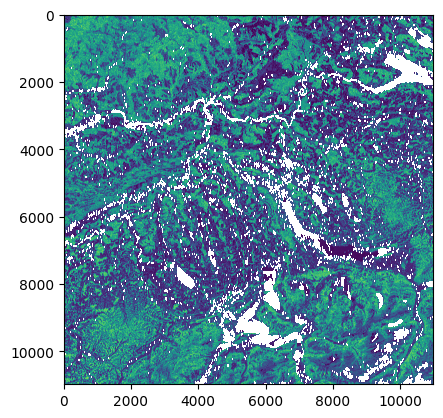

In [22]:
big_image = plt.imshow(image)

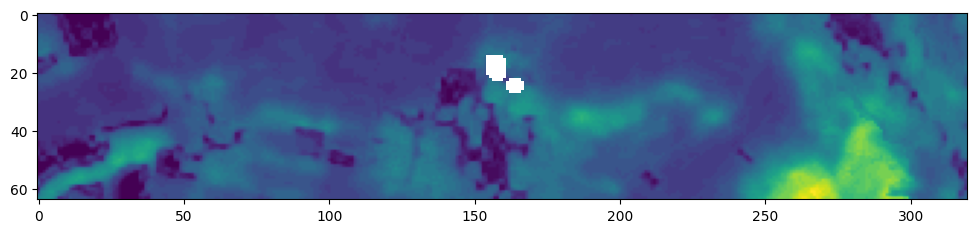

In [69]:
plt.figure(figsize = (12,12))
big_image = plt.imshow(image[0:64,0:64*5])

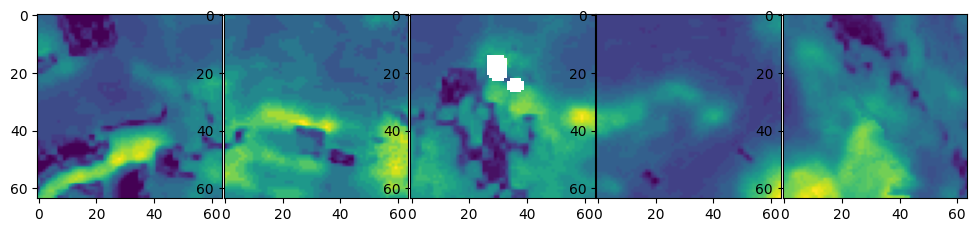

In [82]:
_, axs = plt.subplots(1, 5, figsize=(12, 12))
axs = axs.flatten()
for img, ax in zip(patched_image, axs):
    ax.imshow(img[0])   
plt.subplots_adjust(wspace=0.01)
plt.show()

In [4]:
def projectToTarget(srcshp, target, dtype='uint8'):
    reprojected = np.zeros(target.shape).astype(int)
    
    polygon = fiona.open(srcshp)
    srccrs = polygon.crs
    
    while True:
        try:
            poly = polygon.next()

            poly_trans = rasterio.warp.transform_geom(srccrs, target.crs, poly['geometry'])
            rasterized_polygon = rasterio.features.rasterize(
                [(poly_trans, 1)],
                out_shape=target.shape,
                transform=target.transform,
                fill=0,
                dtype=dtype
            )
            reprojected+=rasterized_polygon
        except:
            break
    
    return reprojected

In [45]:
import os
srcshp = "C:/Users/taylan/pytorchgpu/shp/2020.shp"
jp2_files = []
resolutions = [10,20,60]
# Specify the path to the zip file
for resolution in resolutions:
    jp2_files = []
    zip_path = './S2/S2A_MSIL2A_20200521T102031_N0214_R065_T32TMS_20200521T131814.zip'

    # Specify the path to the image folder within the zip file
    image_folder = 'GRANULE/L2A_T32TMS_A025659_20200521T102644/IMG_DATA/R{}m'.format(resolution)

    # Open the zip file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # Get the list of files in the image folder
        file_list = zip_ref.namelist()

        # Iterate over the files and print the names of JP2 files
        for file_name in file_list:
            # Check if the file belongs to the specified image folder and ends with '.jp2'
            if file_name.startswith(image_folder + '/') and file_name.endswith('.jp2'):
                # Extract the file name and print
                jp2_file_name = os.path.basename(file_name)
                print(jp2_file_name)
                jp2_files.append(jp2_file_name)
    for i in range(len(jp2_files)):
    # Specify the path to the zip file
        zip_path = './S2/S2A_MSIL2A_20200521T102031_N0214_R065_T32TMS_20200521T131814.zip'
        jp2_file = jp2_files[i]
        # Specify the path to the image within the zip file
        image_path = 'GRANULE/L2A_T32TMS_A025659_20200521T102644/IMG_DATA/R{}m/{}'.format(resolution,jp2_file)

        # Open the zip file
        with rasterio.open(f'/vsizip/{zip_path}/{image_path}') as dataset:
            # Access the image properties or perform operations
            # For example, print the number of bands
            print("Number of bands:", dataset.count)
            print(np.sum(projectToTarget(srcshp,dataset)))

T32TMS_20200521T102031_B04_10m.jp2
T32TMS_20200521T102031_B03_10m.jp2
T32TMS_20200521T102031_B02_10m.jp2
T32TMS_20200521T102031_AOT_10m.jp2
T32TMS_20200521T102031_TCI_10m.jp2
T32TMS_20200521T102031_B08_10m.jp2
T32TMS_20200521T102031_WVP_10m.jp2
Number of bands: 1


C:\Users\taylan\AppData\Local\Temp\ipykernel_1580\1889206137.py:9: FionaDeprecationWarning: Collection.__next__() is buggy and will be removed in Fiona 2.0. Switch to `next(iter(collection))`.
  poly = polygon.next()


0
Number of bands: 1
0
Number of bands: 1
0
Number of bands: 1
0
Number of bands: 3
0
Number of bands: 1
0
Number of bands: 1
0
T32TMS_20200521T102031_WVP_20m.jp2
T32TMS_20200521T102031_SCL_20m.jp2
T32TMS_20200521T102031_AOT_20m.jp2
T32TMS_20200521T102031_B05_20m.jp2
T32TMS_20200521T102031_B04_20m.jp2
T32TMS_20200521T102031_B02_20m.jp2
T32TMS_20200521T102031_TCI_20m.jp2
T32TMS_20200521T102031_B07_20m.jp2
T32TMS_20200521T102031_B06_20m.jp2
T32TMS_20200521T102031_B12_20m.jp2
T32TMS_20200521T102031_B11_20m.jp2
T32TMS_20200521T102031_B03_20m.jp2
T32TMS_20200521T102031_B8A_20m.jp2
Number of bands: 1
0
Number of bands: 1
0
Number of bands: 1
0
Number of bands: 1
0
Number of bands: 1
0
Number of bands: 1
0
Number of bands: 3
0
Number of bands: 1
0
Number of bands: 1
0
Number of bands: 1
0
Number of bands: 1
0
Number of bands: 1
0
Number of bands: 1
0
T32TMS_20200521T102031_B03_60m.jp2
T32TMS_20200521T102031_B05_60m.jp2
T32TMS_20200521T102031_WVP_60m.jp2
T32TMS_20200521T102031_B04_60m.jp2
T32T